<a href="https://colab.research.google.com/github/Oluwatobi02/Fashionmodel/blob/main/FashionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch transformers pillow matplotlib

In [ ]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
processor = SegformerImageProcessor.from_pretrained("sayeed99/segformer-b3-fashion")
model = AutoModelForSemanticSegmentation.from_pretrained("sayeed99/segformer-b3-fashion")

In [ ]:
url = "/content/img.jpg"

image = Image.open(url)
inputs = processor(images=image, return_tensors="pt")

In [ ]:
image

In [ ]:
outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

In [ ]:
pred_seg = upsampled_logits.argmax(dim=1)[0]

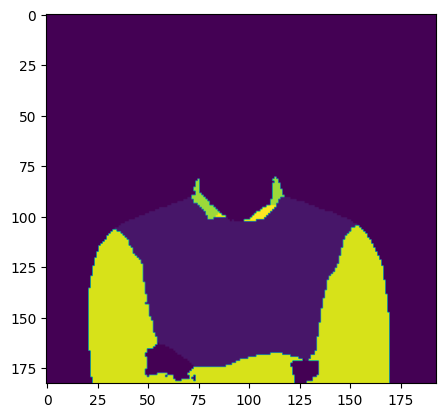

In [ ]:
plt.imshow(pred_seg)

In [ ]:
import numpy as np
unique_cat = np.unique(pred_seg.cpu().numpy())

In [ ]:
categories = model.config.id2label

In [ ]:
for i in unique_cat:
  print(categories[i])

unlabelled
top, t-shirt, sweatshirt
collar
sleeve
neckline


In [ ]:
categories.values()

dict_values(['unlabelled', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel'])

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

# prepare image + question
image = Image.open('/content/IMG_8303.jpg')
text = "what is the color of the socks?"

processor = ViltProcessor.from_pretrained("yanka9/vilt_finetuned_deepfashionVQA_v2")
model = ViltForQuestionAnswering.from_pretrained("yanka9/vilt_finetuned_deepfashionVQA_v2")

# prepare inputs
encoding = processor(image, text, return_tensors="pt")

# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Answer:", model.config.id2label[idx])


Answer: blue


In [ ]:
import pandas as pd

# Example data: list of combinations
data = [
    {
        "File Name": "combo1.jpg",
        "Items": [
            {"Type": "Shirt", "Color": "Blue", "Style": "Casual"},
            {"Type": "Pants", "Color": "Black", "Style": "Formal"}
        ],
        "Validity": "Valid",
        "Rating": 8
    },
    {
        "File Name": "combo2.jpg",
        "Items": [
            {"Type": "Hoodie", "Color": "Grey", "Style": "Casual"},
            {"Type": "Jeans", "Color": "Dark Blue", "Style": "Casual"},
            {"Type": "Watch", "Color": "Silver", "Style": "Formal"}
        ],
        "Validity": "Invalid",
        "Rating": 4
    }
]
df = pd.DataFrame(data)
# Define max number of items
max_items = 5

# Initialize structured rows
structured_data = []
for combo in data:
    row = {"File Name": combo["File Name"]}
    # Add each item's attributes to fixed columns
    for i in range(max_items):
        if i < len(combo["Items"]):  # Populate existing items
            item = combo["Items"][i]
            row[f"Item{i+1}_Type"] = item["Type"]
            row[f"Item{i+1}_Color"] = item["Color"]
            row[f"Item{i+1}_Style"] = item["Style"]
        else:  # Fill placeholders for missing items
            row[f"Item{i+1}_Type"] = "None"
            row[f"Item{i+1}_Color"] = "None"
            row[f"Item{i+1}_Style"] = "None"
    # Add target variables
    row["Validity"] = 1 if combo["Validity"] == "Valid" else 0
    row["Rating"] = combo["Rating"]
    structured_data.append(row)

# Create DataFrame
df = pd.DataFrame(structured_data)
df
